# Dataset: CK+

## Import Libraries

In [1]:
from numba import cuda
cuda.select_device(0)
cuda.close()

In [2]:
import os
import numpy as np
import pandas as pd
import cv2

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import keras
from keras.utils import np_utils

import urllib.request

from keras import callbacks

from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

import keras.backend as K

from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt




## Data Collection

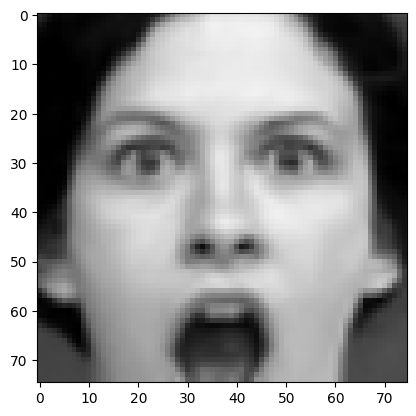

In [3]:

data_path = 'CK+48/'
data_dir_list = os.listdir(data_path)

img_data_list=[]
for dataset in data_dir_list:
    img_list=os.listdir(data_path+'/'+ dataset)
    for img in img_list:
        input_img=cv2.imread(data_path + '/'+ dataset + '/'+ img )
        input_img_resize=cv2.resize(input_img,(75,75))
        img_data_list.append(input_img_resize)
        
img_data = np.array(img_data_list)
img_data = img_data.astype('float32')
img_data = img_data/255
plt.imshow(input_img_resize)

In [4]:
num_of_samples = img_data.shape[0]
labels = np.ones((num_of_samples,),dtype='int64')

labels[0:29]=0 
labels[30:58]=1 
labels[59:90]=2 
labels[91:121]=3 
labels[122:151]=4 
labels[152:182]=5 
labels[183:]=6 

names = ['ANGRY','DISGUST','FEAR','HAPPY','NEUTRAL','SAD','SURPRISE']

def getLabel(id):
    return ['ANGRY','DISGUST','FEAR','HAPPY','NEUTRAL','SAD','SURPRISE'][id]

In [5]:
Y = np_utils.to_categorical(labels, 7)
x,y = shuffle(img_data,Y)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=2)
x_test=X_test

## Model Building

In [6]:
pre_trained_model = InceptionV3(input_shape = (75, 75, 3), 
                                include_top = False, 
                                weights = 'imagenet')

for layer in pre_trained_model.layers:
    layer.trainable = False
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 75, 75, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 37, 37, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 37, 37, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 37, 37, 32)   0           ['batch_normalization[

In [7]:
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 3, 3, 768)


In [8]:
base_learning_rate = 0.0001

In [9]:
#EVALUATION

def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [10]:
#EVALUATION

METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
      f1_score,
]

In [11]:
x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.5)(x)  
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)                  
x = layers.Dense  (7, activation='softmax')(x)           

model = Model(pre_trained_model.input, x) 

model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate), 
              loss = 'categorical_crossentropy', 
              metrics = METRICS)

In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 75, 75, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 37, 37, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 37, 37, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 37, 37, 32)   0           ['batch_normalization[0][0]']

In [13]:
train_datagen = ImageDataGenerator(rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)


train_generator = train_datagen.flow(X_train,y_train,batch_size = 16)     


In [14]:
initial_epoch = 50

In [15]:
# Create Callback Checkpoint
filepath="Best1.hdf5"
Checkpoint = callbacks.ModelCheckpoint(filepath, monitor='val_loss',save_best_only=True, mode='min')

callbacks_list1 = [Checkpoint]

In [16]:
history = model.fit(
            train_generator,
            epochs = initial_epoch,validation_data=(x_test,y_test),callbacks=callbacks_list1)

Epoch 1/50
49/49 [==============================] - 14s 88ms/step - loss: 1.0349 - accuracy: 0.9359 - precision: 0.8059 - recall: 0.7258 - auc: 0.8996 - f1_score: 0.7500 - val_loss: 0.9020 - val_accuracy: 0.9434 - val_precision: 0.8020 - val_recall: 0.8020 - val_auc: 0.9086 - val_f1_score: 0.8259
Epoch 2/50
49/49 [==============================] - 2s 37ms/step - loss: 0.8562 - accuracy: 0.9431 - precision: 0.8224 - recall: 0.7679 - auc: 0.9190 - f1_score: 0.7933 - val_loss: 0.7878 - val_accuracy: 0.9449 - val_precision: 0.8103 - val_recall: 0.8020 - val_auc: 0.9292 - val_f1_score: 0.8294
Epoch 3/50
49/49 [==============================] - 1s 28ms/step - loss: 0.7687 - accuracy: 0.9472 - precision: 0.8479 - recall: 0.7679 - auc: 0.9372 - f1_score: 0.8049 - val_loss: 0.8402 - val_accuracy: 0.9434 - val_precision: 0.8020 - val_recall: 0.8020 - val_auc: 0.9435 - val_f1_score: 0.8259
Epoch 4/50
49/49 [==============================] - 2s 36ms/step - loss: 0.7559 - accuracy: 0.9477 - precisi

## Quantitative Evaluation

In [17]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_auc = history.history['auc']
val_auc = history.history['val_auc']

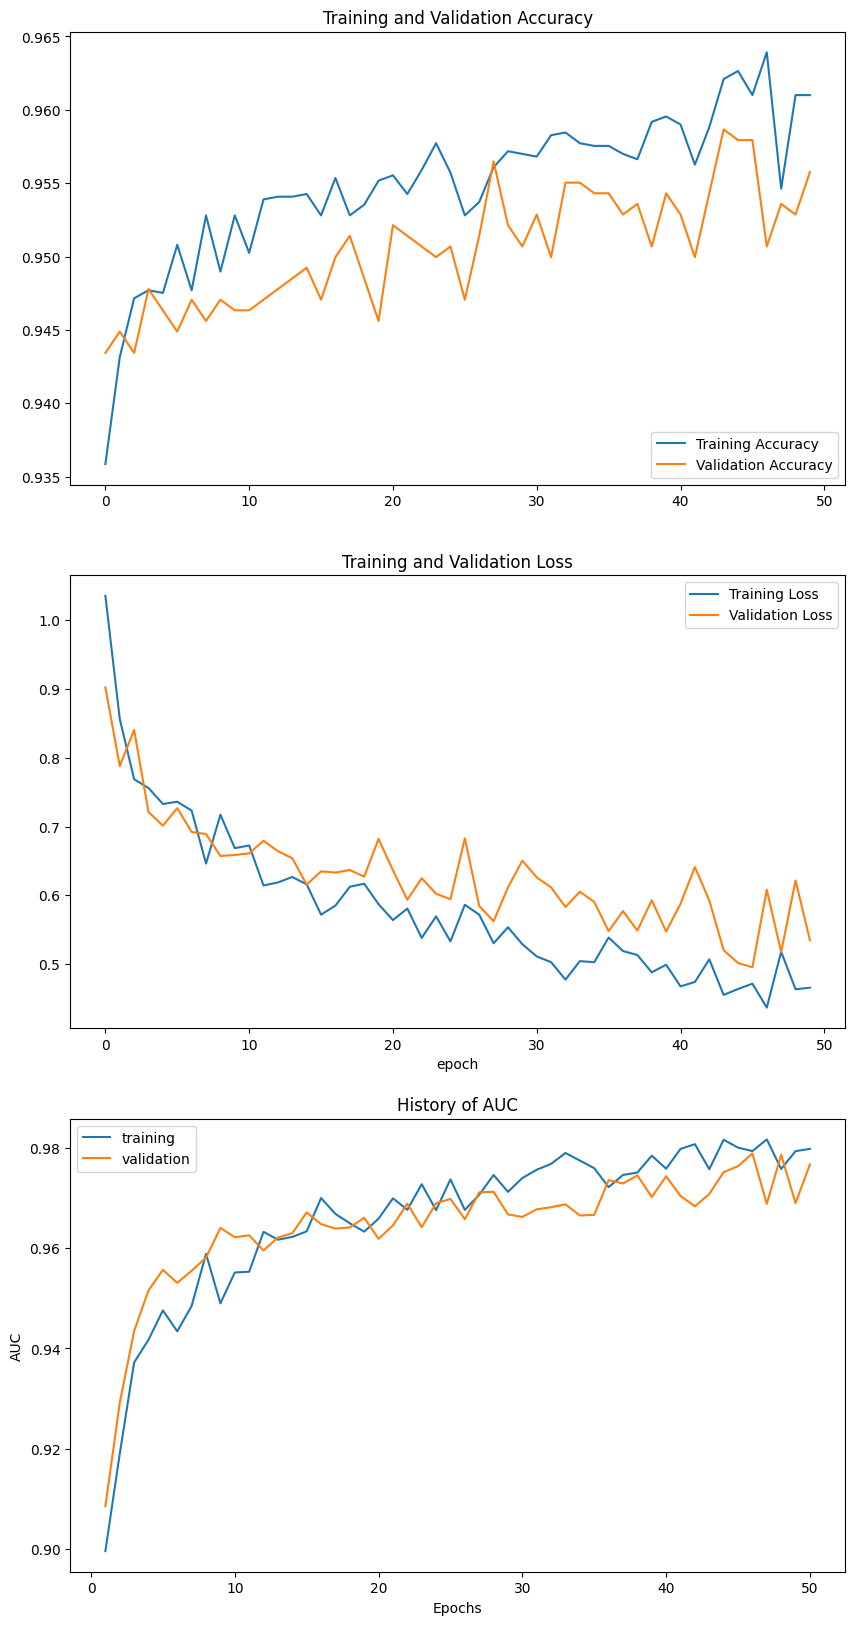

In [18]:
epochs_range = range(len(train_acc))

plt.figure(figsize=(10, 20))
plt.subplot(3, 1, 1)
plt.plot(epochs_range, train_acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(3, 1, 2)
plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')

plt.subplot(3, 1, 3)
plt.plot(range(1, len(train_auc) + 1), train_auc)
plt.plot(range(1, len(val_auc) + 1), val_auc)
plt.title('History of AUC')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend(['training', 'validation'])
plt.show()
    

In [19]:
#EVALUATION

print('Train Accuracy: ', round(history.history['accuracy'][-1],2))
print('Train Loss: ', round(history.history['loss'][-1],2))
print('Train Precision: ', round(history.history['precision'][-1],2))
print('Train Recall: ', round(history.history['recall'][-1],2))
print('Train F1-Score: ', round(history.history['f1_score'][-1],2))

Train Accuracy:  0.96
Train Loss:  0.47
Train Precision:  0.91
Train Recall:  0.81
Train F1-Score:  0.85


In [20]:
#EVALUATION

print('Test Accuracy: ', round(history.history['val_accuracy'][-1],2))
print('Test Loss: ', round(history.history['val_loss'][-1],2))
print('Test Precision: ', round(history.history['val_precision'][-1],2))
print('Test Recall: ', round(history.history['val_recall'][-1],2))
print('Test F1-Score: ', round(history.history['val_f1_score'][-1],2))

Test Accuracy:  0.96
Test Loss:  0.54
Test Precision:  0.89
Test Recall:  0.79
Test F1-Score:  0.86


## Fine Tuning

In [21]:
NB_IV3_LAYERS_TO_FREEZE = 172

In [22]:
for layer in model.layers[:NB_IV3_LAYERS_TO_FREEZE]:
    layer.trainable = False
for layer in model.layers[NB_IV3_LAYERS_TO_FREEZE:]:
    layer.trainable = True
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate), metrics = METRICS,   
                 loss='categorical_crossentropy')

In [23]:
# Create Callback Checkpoint
filepath="Best1.hdf5"
Checkpoint = callbacks.ModelCheckpoint(filepath, monitor='val_loss',save_best_only=True, mode='min')

callbacks_list2 = [Checkpoint]

In [24]:
fine_tune_epochs = 30
total_epochs =  initial_epoch + fine_tune_epochs

history_fine = model.fit(train_generator,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=(x_test,y_test),
                         callbacks = callbacks_list2)

Epoch 50/80
49/49 [==============================] - 8s 69ms/step - loss: 0.7464 - accuracy: 0.9470 - precision: 0.8502 - recall: 0.7635 - auc: 0.9481 - f1_score: 0.7957 - val_loss: 1.4690 - val_accuracy: 0.9434 - val_precision: 0.8020 - val_recall: 0.8020 - val_auc: 0.9070 - val_f1_score: 0.8259
Epoch 51/80
49/49 [==============================] - 2s 47ms/step - loss: 0.6048 - accuracy: 0.9521 - precision: 0.8643 - recall: 0.7883 - auc: 0.9645 - f1_score: 0.8240 - val_loss: 0.8804 - val_accuracy: 0.9463 - val_precision: 0.8154 - val_recall: 0.8071 - val_auc: 0.9500 - val_f1_score: 0.8338
Epoch 52/80
49/49 [==============================] - 2s 45ms/step - loss: 0.5753 - accuracy: 0.9550 - precision: 0.8897 - recall: 0.7819 - auc: 0.9698 - f1_score: 0.8310 - val_loss: 0.7774 - val_accuracy: 0.9471 - val_precision: 0.8196 - val_recall: 0.8071 - val_auc: 0.9606 - val_f1_score: 0.8357
Epoch 53/80
49/49 [==============================] - 2s 45ms/step - loss: 0.5113 - accuracy: 0.9585 - prec

## Quantitative Evaluation

In [25]:
train_acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']
train_loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']
train_auc += history_fine.history['auc']
val_auc += history_fine.history['val_auc']

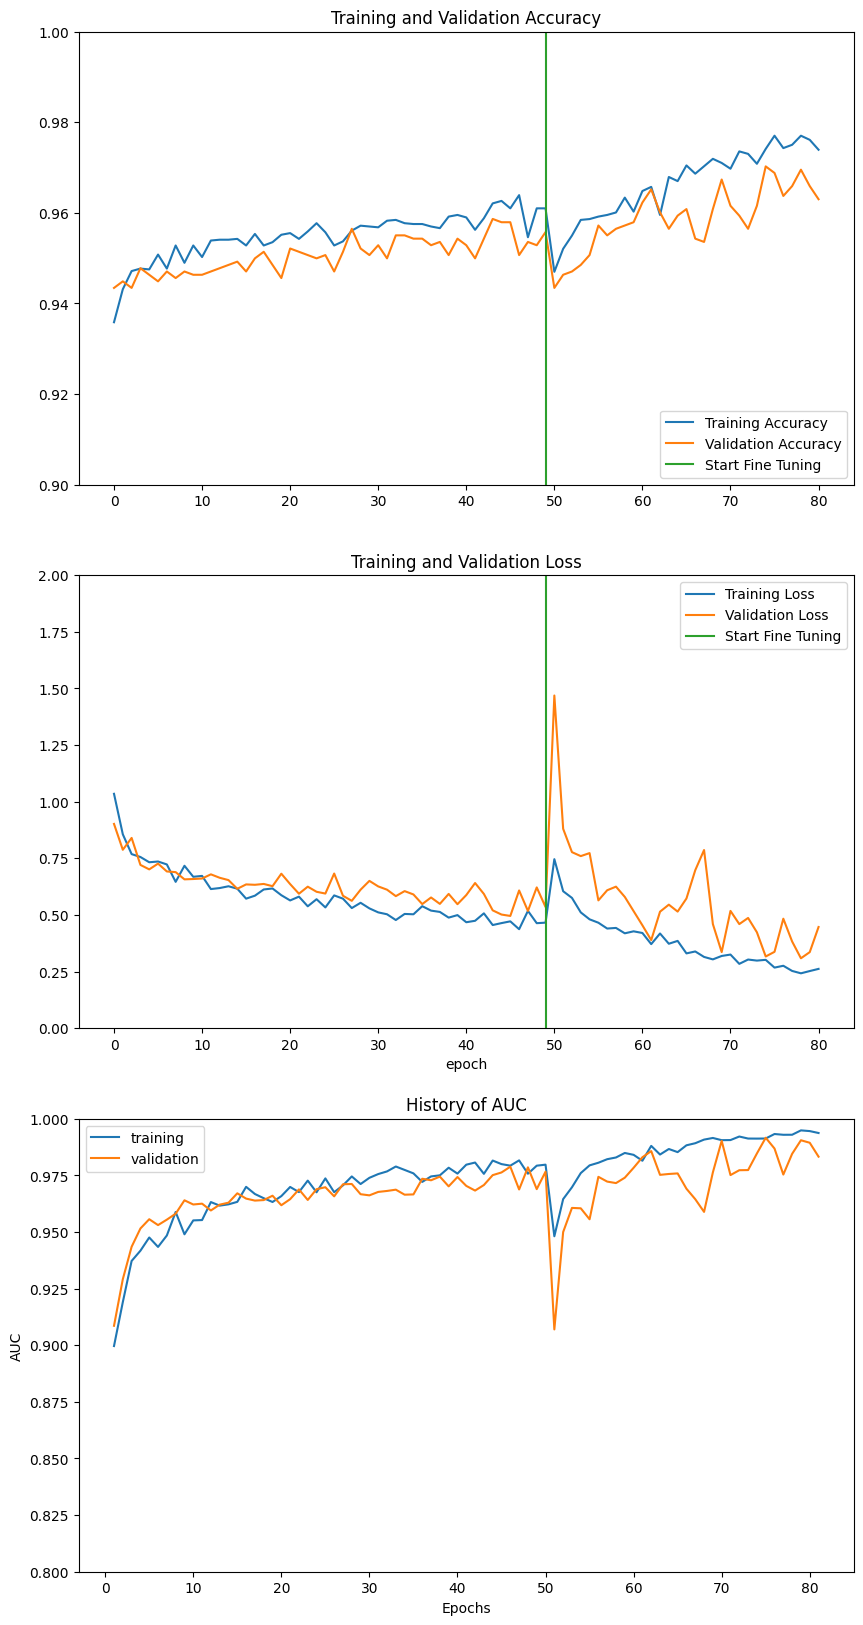

In [26]:
epochs_range = range(len(train_acc))

plt.figure(figsize=(10, 20))
plt.subplot(3, 1, 1)
plt.ylim(0.9, 1)
plt.plot(epochs_range, train_acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.plot([initial_epoch-1,initial_epoch-1], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(3, 1, 2)
plt.ylim(0,2)
plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.plot([initial_epoch-1,initial_epoch-1], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')

plt.subplot(3, 1, 3)
plt.ylim(0.8, 1)
plt.plot(range(1, len(train_auc) + 1), train_auc)
plt.plot(range(1, len(val_auc) + 1), val_auc)
plt.title('History of AUC')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend(['training', 'validation'])
plt.show()
    

In [27]:
#EVALUATION

print('Train Accuracy: ', round(history_fine.history['accuracy'][-1],2))
print('Train Loss: ', round(history_fine.history['loss'][-1],2))
print('Train Precision: ', round(history_fine.history['precision'][-1],2))
print('Train Recall: ', round(history_fine.history['recall'][-1],2))
print('Train F1-Score: ', round(history_fine.history['f1_score'][-1],2))

Train Accuracy:  0.97
Train Loss:  0.26
Train Precision:  0.93
Train Recall:  0.88
Train F1-Score:  0.91


In [28]:
#EVALUATION

print('Test Accuracy: ', round(history_fine.history['val_accuracy'][-1],2))
print('Test Loss: ', round(history_fine.history['val_loss'][-1],2))
print('Test Precision: ', round(history_fine.history['val_precision'][-1],2))
print('Test Recall: ', round(history_fine.history['val_recall'][-1],2))
print('Test F1-Score: ', round(history_fine.history['val_f1_score'][-1],2))

Test Accuracy:  0.96
Test Loss:  0.45
Test Precision:  0.88
Test Recall:  0.85
Test F1-Score:  0.88


7/7 [==============================] - 1s 19ms/step


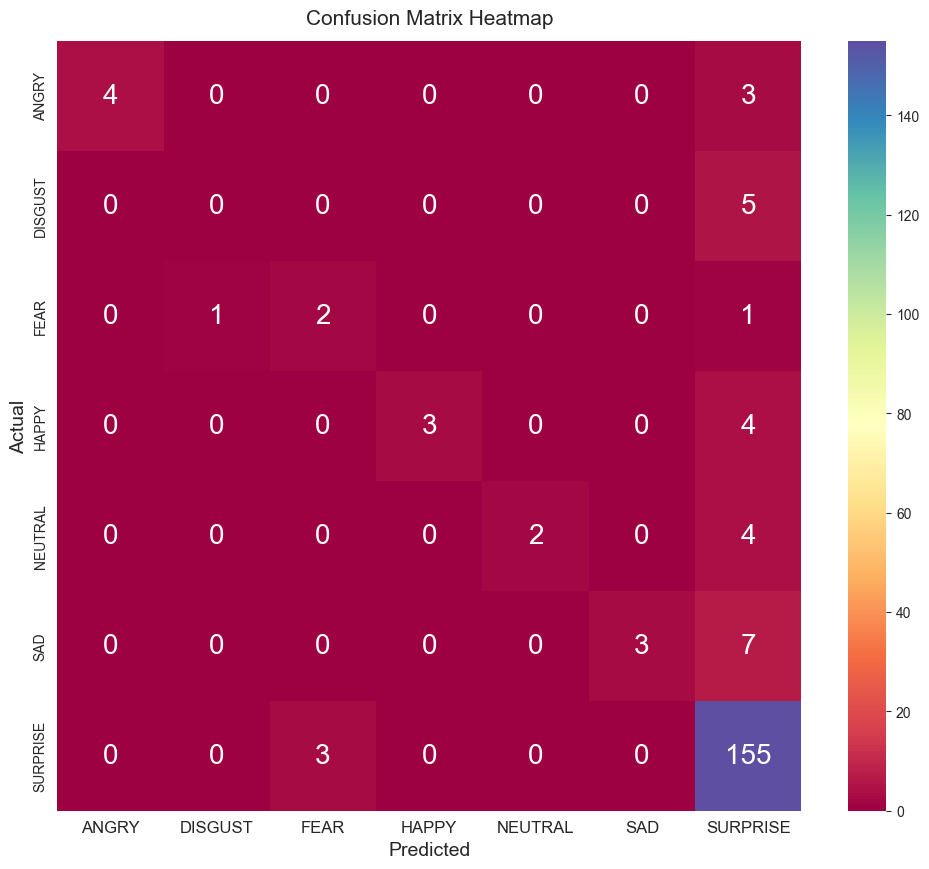

In [29]:
import seaborn as sns 
from sklearn.metrics import confusion_matrix
Y_pred = model.predict(X_test)
Y_pred = np.argmax(Y_pred, axis=1)
conf_mat = confusion_matrix(np.where(y_test == 1)[1],Y_pred)
sns.set_style(style='dark')
plt.figure(figsize=(12,10))
heatmap = sns.heatmap(conf_mat,vmin=np.min(conf_mat.all()), vmax=np.max(conf_mat), annot=True,fmt='d', annot_kws={"fontsize":20},cmap='Spectral')
heatmap.set_title('Confusion Matrix Heatmap', fontdict={'fontsize':15}, pad=12)
heatmap.set_xlabel('Predicted',fontdict={'fontsize':14})
heatmap.set_ylabel('Actual',fontdict={'fontsize':14})
heatmap.set_xticklabels(['ANGRY','DISGUST','FEAR','HAPPY','NEUTRAL','SAD','SURPRISE'], fontdict={'fontsize':12})
heatmap.set_yticklabels(['ANGRY','DISGUST','FEAR','HAPPY','NEUTRAL','SAD','SURPRISE'], fontdict={'fontsize':10})
plt.show()

## Qualitative Evaluation

1/1 [==============================] - 0s 175ms/step


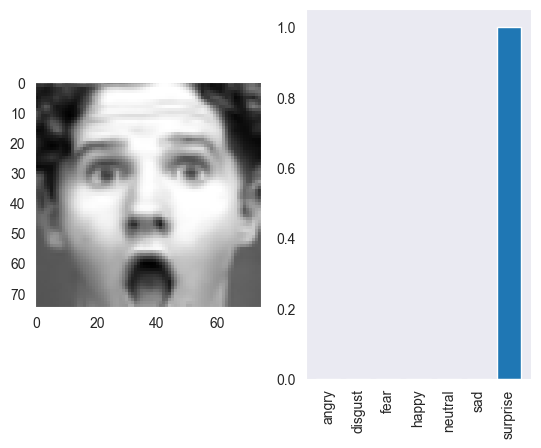

Expression Prediction: surprise
1/1 [==============================] - 0s 27ms/step


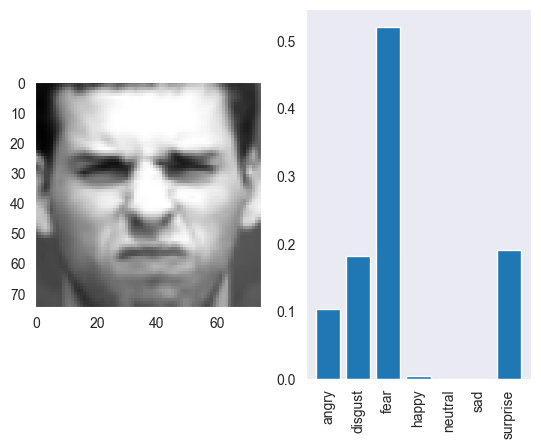

Expression Prediction: fear
1/1 [==============================] - 0s 28ms/step


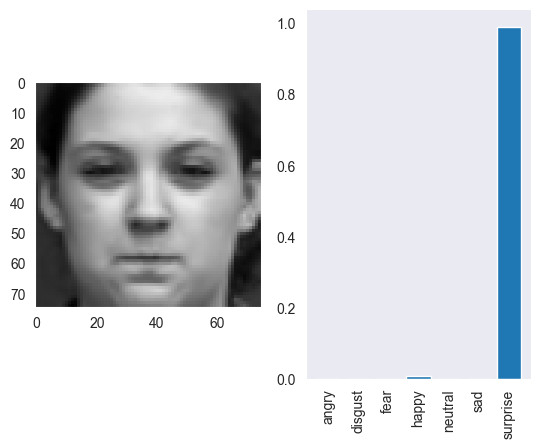

Expression Prediction: surprise
1/1 [==============================] - 0s 27ms/step


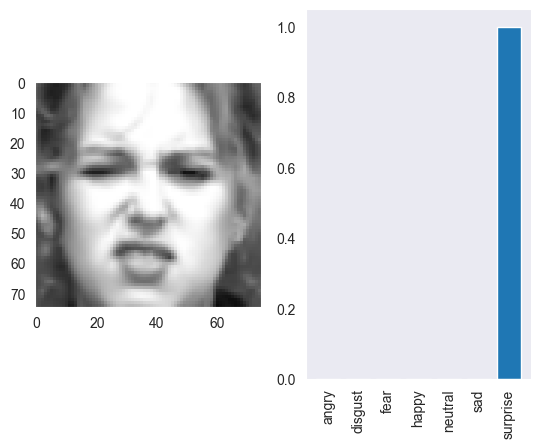

Expression Prediction: surprise
1/1 [==============================] - 0s 28ms/step


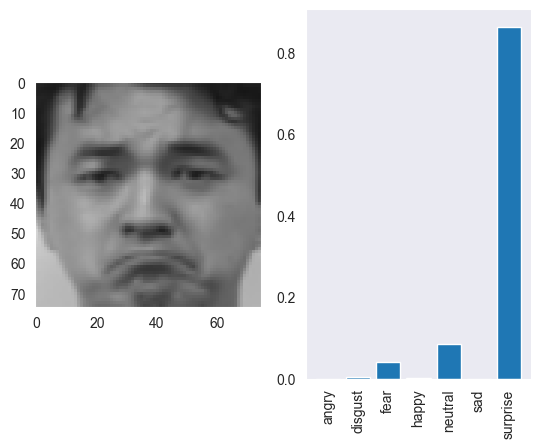

Expression Prediction: surprise
1/1 [==============================] - 0s 29ms/step


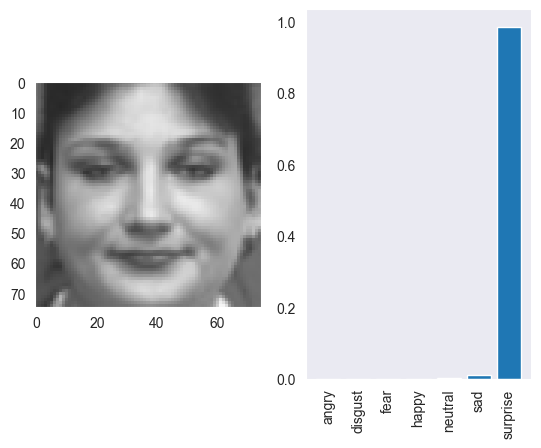

Expression Prediction: surprise
1/1 [==============================] - 0s 27ms/step


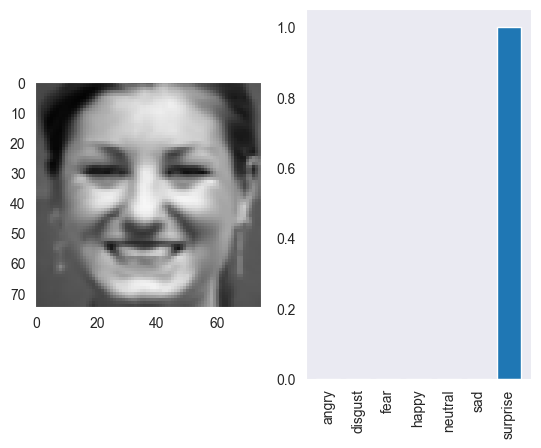

Expression Prediction: surprise
1/1 [==============================] - 0s 29ms/step


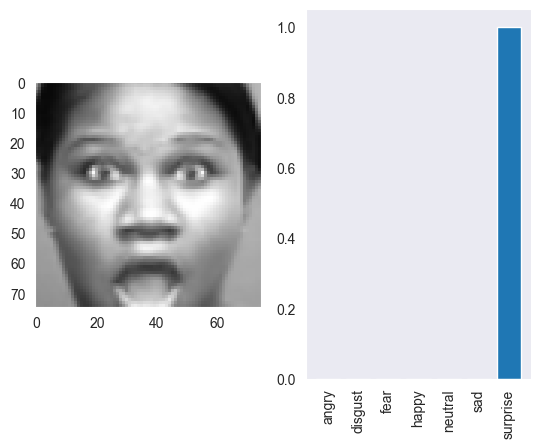

Expression Prediction: surprise
1/1 [==============================] - 0s 29ms/step


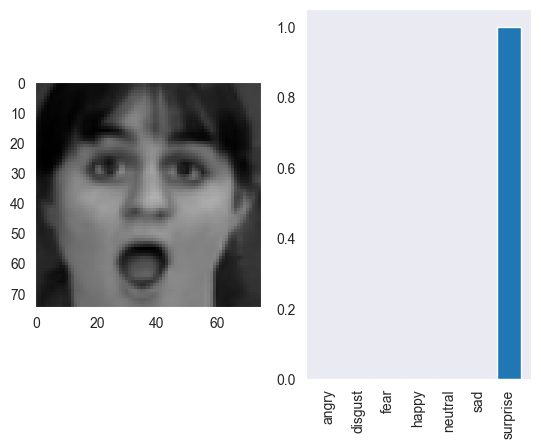

Expression Prediction: surprise
1/1 [==============================] - 0s 30ms/step


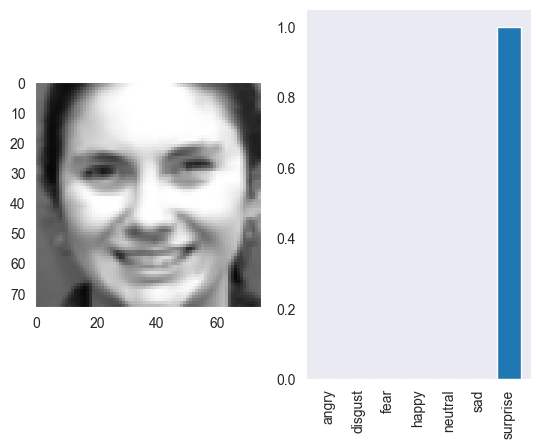

Expression Prediction: surprise
1/1 [==============================] - 0s 30ms/step


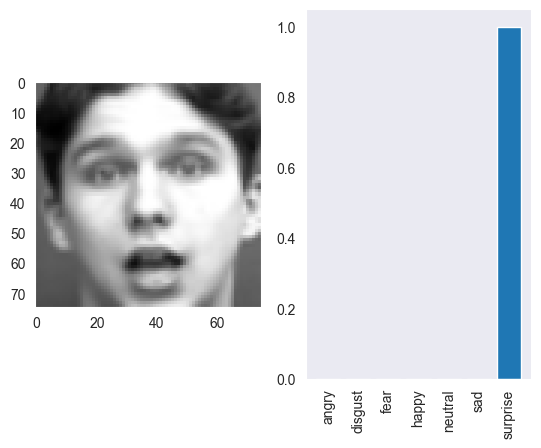

Expression Prediction: surprise
1/1 [==============================] - 0s 29ms/step


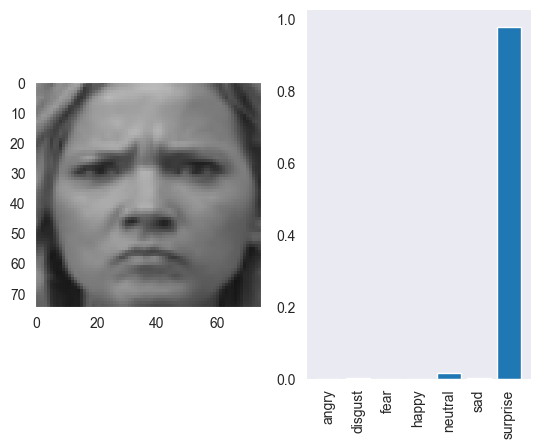

Expression Prediction: surprise
1/1 [==============================] - 0s 29ms/step


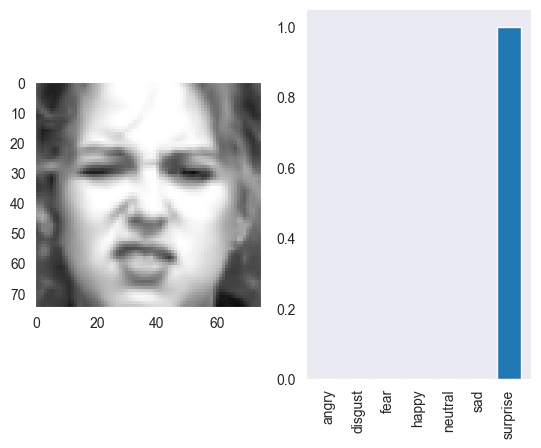

Expression Prediction: surprise
1/1 [==============================] - 0s 29ms/step


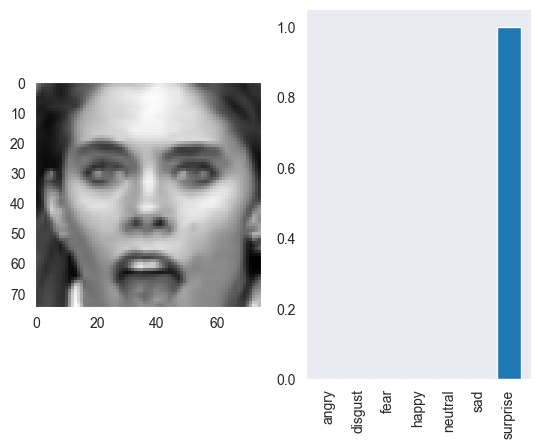

Expression Prediction: surprise
1/1 [==============================] - 0s 28ms/step


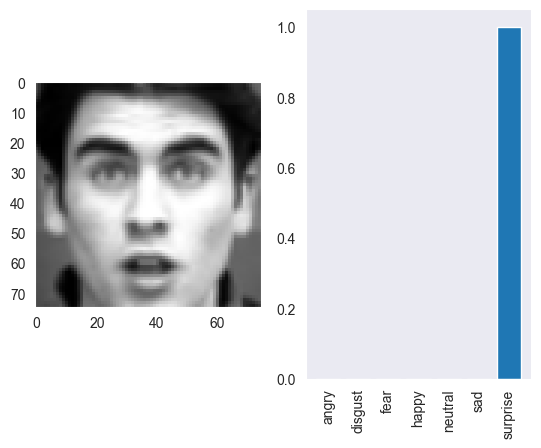

Expression Prediction: surprise
1/1 [==============================] - 0s 27ms/step


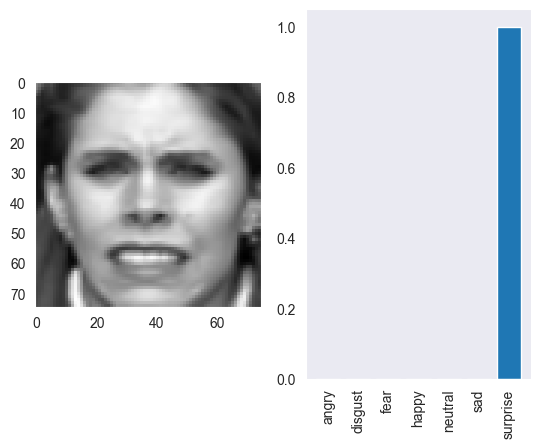

Expression Prediction: surprise
1/1 [==============================] - 0s 28ms/step


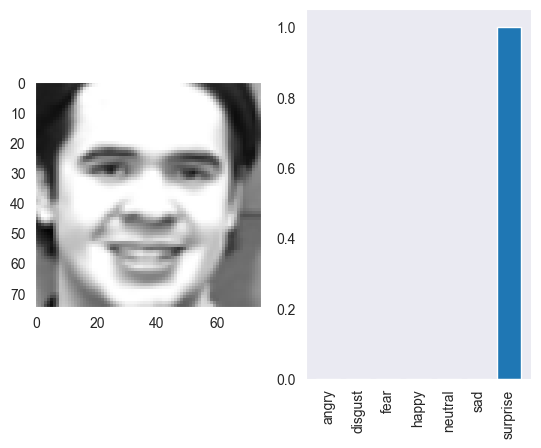

Expression Prediction: surprise
1/1 [==============================] - 0s 40ms/step


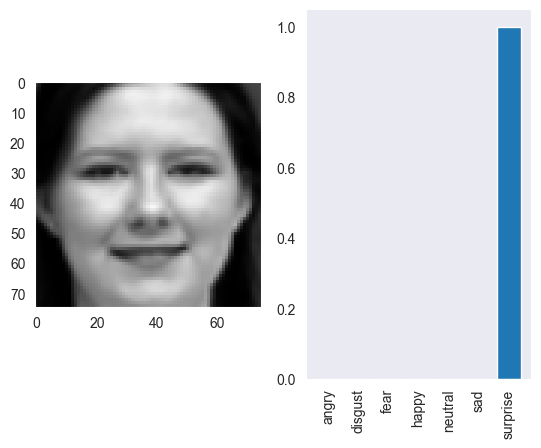

Expression Prediction: surprise
1/1 [==============================] - 0s 28ms/step


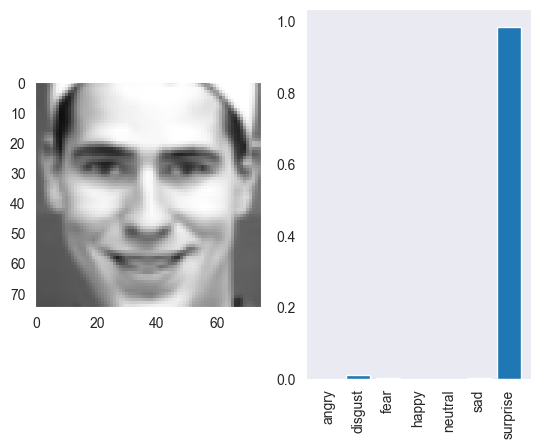

Expression Prediction: surprise
1/1 [==============================] - 0s 29ms/step


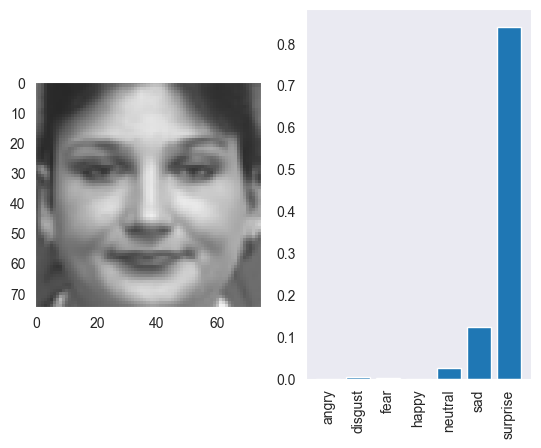

Expression Prediction: surprise


In [30]:
objects = ('angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise')

for i in range(0, 20):
    
    x = X_test[i:i+1]

    custom = model.predict(x)

    x = np.array(x, 'float32')
    x = x.reshape([75, 75, 3]);

    plt.gray()
    plt.subplot(1,2,1)
    plt.imshow(X_test[i],cmap=plt.get_cmap('gray'))
    
    plt.subplot(1,2,2)
    plt.bar(objects,custom[0])
    plt.xticks(rotation=90)
    
    plt.show()

    a = custom[0]
    m = a[0]
    for i in range(0,len(a)):
        if a[i] >= m:
            m = a[i]
            ind = i

    print('Expression Prediction:',objects[ind])

Test Loss: 0.44680243730545044
Test accuracy: 0.9630166888237
1/1 [==============================] - 0s 175ms/step
[6 2 6 6 6 6 6 6 6]
[6 6 3 6 6 5 6 6 6]


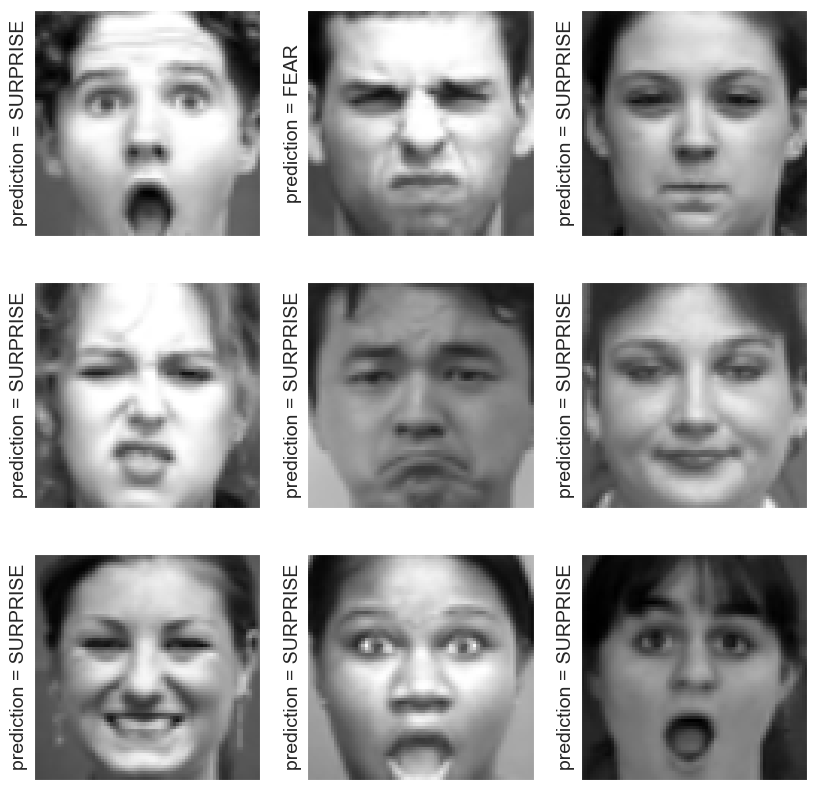

In [31]:
# Evaluating the model
score = model.evaluate(X_test, y_test, verbose=0)
print('Test Loss:', score[0])
print('Test accuracy:', score[1])

res = model.predict(X_test[:9]).argmax(axis=-1)
print(res)
print(y_test[:9].argmax(axis=-1))
plt.figure(figsize=(10, 10))

for i in range(0, 9):
    plt.subplot(330 + 1 + i)
    plt.imshow(X_test[i],cmap=plt.get_cmap('gray'))
    plt.gca().get_xaxis().set_ticks([])
    plt.gca().get_yaxis().set_ticks([])
    plt.ylabel('prediction = %s' % getLabel(res[i]), fontsize=14)

# show the plot
plt.show()
